In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as mt
import julia
import os
import random as rd

from julia.api import Julia
jl = Julia(compiled_modules=False)

from julia import Base
from julia import Main
#from julia import DifferentialEquations
from julia import DynamicalSystems

from matplotlib import rc
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


### Energy

In [47]:
E = 0.08333
Ename = "008333"

----------------------------------------
----------------------------------------
----------------------------------------

In [51]:
Main.E = E

%julia ics_select = []
%julia i = 1
%julia ics = DynamicalSystems.Systems.henonheiles_ics(E, 300)[5000:end]
%julia for ic in ics; if ic[2] > -0.1 && ic[2] < 0.4 && ic[4] > -0.1 && ic[4] < 0.1; push!(ics_select, ic); end; end;
%julia length(ics_select)

6360

In [52]:
x_train = []
y_train = []
for i in range(1, 5000, 100):
    
    print(i)
    Main.i = i
    %julia T = 100. ; dt = 0.001
    %julia ds = DynamicalSystems.Systems.henonheiles(ics_select[i])
    %julia x = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,1];
    %julia y = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,2];
    %julia xdot = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,3];
    %julia ydot = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,4];


    x = Main.x.tolist()
    y = Main.y.tolist()
    xdot = Main.xdot.tolist()
    ydot = Main.ydot.tolist()

    Ty=[y[0]]
    Tydot=[ydot[0]]

    #Ty.append(y[0])
    #Tydot.append(ydot[0])

    s = np.sign(x[1])

    for i in range(1,len(x)):

        if np.sign(x[i]) != s:
            if xdot[i]>0:
                Ty.append(y[i])
                Tydot.append(ydot[i])
            s = np.sign(x[i])
    
    print(len(Ty))

    x_train = x_train + [np.array([Ty[i],Tydot[i]]) for i in range(len(Ty)-1)]
    y_train = y_train + [np.array([Ty[i],Tydot[i]]) for i in range(1,len(Ty))]

len(x_train)

1
15
101
16
201
16
301
15
401
16
501
16
601
15
701
16
801
16
901
16
1001
16
1101
16
1201
16
1301
16
1401
16
1501
16
1601
16
1701
16
1801
16
1901
16
2001
16
2101
16
2201
16
2301
16
2401
16
2501
16
2601
17
2701
16
2801
17
2901
17
3001
16
3101
17
3201
17
3301
16
3401
17
3501
17
3601
16
3701
17
3801
17
3901
16
4001
17
4101
17
4201
17
4301
17
4401
17
4501
17
4601
17
4701
17
4801
17
4901
17


766

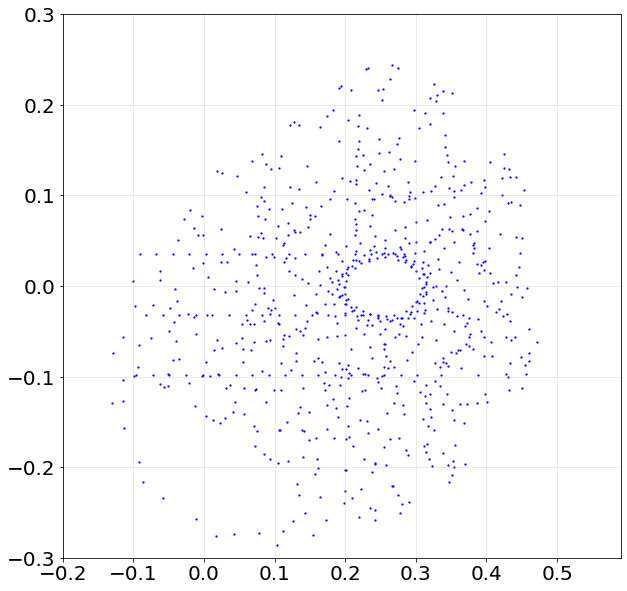

In [53]:
plt.figure(figsize=(10,10))
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.title(r'True Poincar\'e Plot H\'enon-Heiles, E=0.1', fontsize = 35)
plt.scatter(*zip(*x_train), color = "b", linewidth = 0, s=5)
#plt.scatter(*zip(*y_train), color = "r", linewidth = 0, s=5)
#plt.xlabel(r'$y$', fontsize=28, labelpad=8)
#plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.grid(axis='both', alpha=.3)
plt.xlim(-0.2, 0.59)
plt.ylim(-0.3, 0.3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
#plt.savefig("True_01")
plt.show()

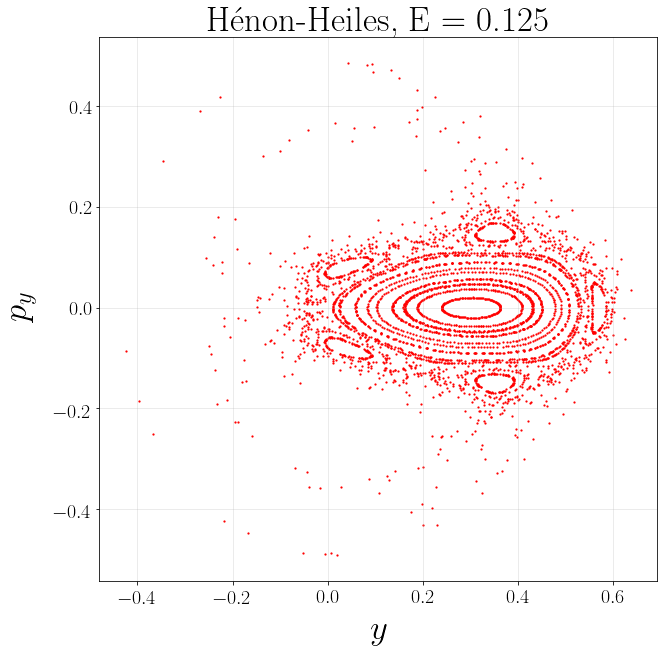

In [37]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'H\'enon-Heiles, E = ' + str(E), fontsize = 35)
plt.scatter(*zip(*x_train), color = "r", label = r'$\mathcal{T}^{2}(x)$, learned', linewidth = 0, s=5)
plt.xlabel(r'$y$', fontsize=35, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=35, labelpad=15)
plt.grid(axis='both', alpha=.3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xlim(-0.2, 0.6)
#plt.ylim(-0.33, 0.33)
#plt.legend(fontsize = 15, loc = 'upper right')
plt.savefig("Poincare_HH_0125")
plt.show()

In [54]:
c = list(zip(x_train, y_train))

rd.shuffle(c)

x_train, y_train = zip(*c)

In [55]:
os.remove("x_train_"+ Ename +".txt")
f = open("x_train_" + Ename + ".txt", "a")
for i in x_train:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()

In [56]:
os.remove("y_train_"+ Ename +".txt")
f = open("y_train_"+ Ename +".txt", "a")
for i in y_train:
    f.write(str(i[0]))
    f.write("\n")
    f.write(str(i[1]))
    f.write("\n")
f.close()